<a href="https://colab.research.google.com/github/giakomorssi/AI-Snake/blob/main/02_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import mean_squared_error

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

!pip install -q category_encoders

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runtime switched to GPU
GPU device found: /device:GPU:0
Default GPU Device: /device:GPU:0


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Cleaning the Data

In [ ]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password', 'Customer Country', 'Customer Id', 'Customer Fname', 'Customer Lname', 'Customer Street', 'Order Country', 'Product Card Id', 'Product Category Id', 'Product Image', 'Customer State', 'shipping date (DateOrders)', 'order date (DateOrders)'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

In [ ]:
df.to_csv('/content/drive/MyDrive/University/Deloitte/df_lr.csv', index = False)

## Encoding

### Label Encoding

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['Days for shipping (real)', 'Product Name'], axis = 1)
y = df['Days for shipping (real)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder

# initialize the encoder
enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City', 'Order State', 'Order Region'])

# fit and transform the entire dataset
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Select columns for one-hot encoding
one_hot_cols = [0, 7, 9, 12, 15, 30]
# Type, Department Name, Category Name, Market, Order Status, Customer Segment

# Fit one-hot encoder to training data
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# Apply one-hot encoder to training and test data
X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

# Remove original columns from training and test data
X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

# Concatenate one-hot encoded columns with remaining data
X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Shipping Mode
custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
le.fit(custom_order)
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

# Delivery Status
# Define the custom order
custom_order = ['Shipping on time', 'Advance shipping', 'Late delivery', 'Shipping canceled']
le.fit(custom_order)
X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

## Scale the Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train.iloc[:, 82:] = scaler.fit_transform(X_train.iloc[:, 82:])
X_test.iloc[:, 82:] = scaler.transform(X_test.iloc[:, 82:])

<ipython-input-60-6700864cfc85>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train.iloc[:, 82:] = scaler.fit_transform(X_train.iloc[:, 82:])
<ipython-input-60-6700864cfc85>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.iloc[:, 82:] = scaler.transform(X_test.iloc[:, 82:])


In [ ]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Prediction

## Choosing the Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100, max_depth=None)

# Fit the model
model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models_lr/rf.pkl', 'wb') as file:
    pickle.dump(model, file)

mean_squared_error(y_test, model.predict(X_test), squared=False)

0.7503090876504547

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth=None)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models_lr/xgb.pkl', 'wb') as file:
    pickle.dump(model, file)

mean_squared_error(y_test, model.predict(X_test), squared=False)

0.8384870591728664

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the neural network architecture
model = Sequential()
model.add(Dense(516, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='linear'))

# Compile the model with mean squared error loss function and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Evaluate the model on the test data
loss, mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error on test set: {:.2f}'.format(mse))

# Plot the training and validation loss over epochs
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# gradiant boosting
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models_lr/gb.pkl', 'wb') as file:
    pickle.dump(model, file)

mean_squared_error(y_test, model.predict(X_test), squared=False)

0.639807823600399

In [ ]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Fit the model using QuantReg
quant_model = sm.QuantReg(y_train, X_train)

# Set the tau value to 0.5, which corresponds to median regression
quant_result = quant_model.fit(q=0.7, max_iter=2000)

# Print the summary of the model
#print(quant_result.summary())

# Make predictions on new data
new_data = X_test
predictions = quant_result.predict(new_data)

mean_squared_error(y_test, predictions, squared=False)

0.802427350097214

## Performance of the Model

In [ ]:
import pickle

with open('/content/drive/MyDrive/University/Deloitte/models_lr/rf.pkl', 'rb') as f:
    model = pickle.load(f)

y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

### Over 20 Splits

Cloning into 'Deloitte_Project'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 113 (delta 51), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (113/113), 2.90 MiB | 13.04 MiB/s, done.
Resolving deltas: 100% (51/51), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 5.9 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

MSE Mean: 0.7948020859184577
MSE Std: 0.008090843840177856
Within Threshold Mean: 0.6315020496343895
Within Threshold Std: 0.0022706569726639123


## Visualization

In [24]:
# Distribution plot

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')

# Set style for the plot
sns.set_style('darkgrid')

# Create a distribution plot
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(y_pred, label='Predicted', fill=True)
plt.xlabel('Delivery time')
plt.ylabel('Density')
plt.title('Distribution Plot')
plt.legend()
plt.show()

NameError: ignored

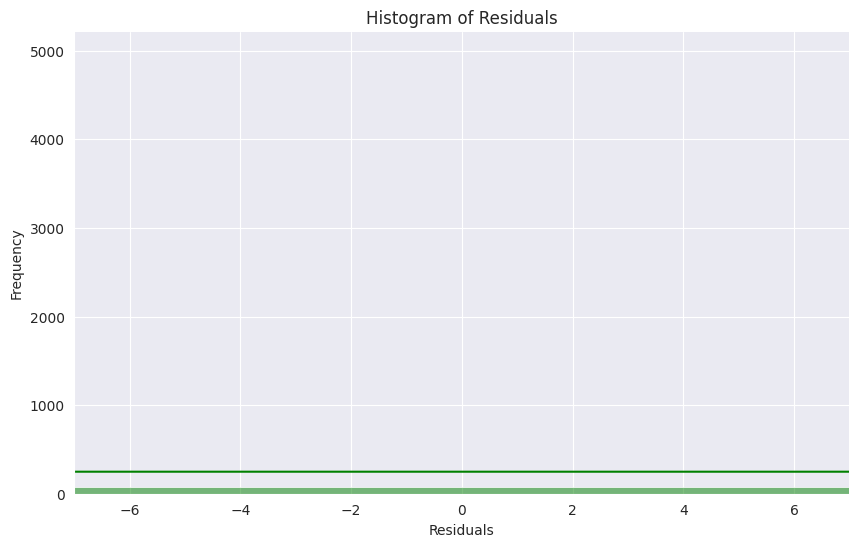

In [ ]:
# Plot a histogram of the residuals

import seaborn as sns
import matplotlib.pyplot as plt

# Set style for the plot
sns.set_style('darkgrid')

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram with specified number of bins and color
sns.histplot(residuals, bins=100, color='green', kde=True, ax=ax)

# Set labels and title
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Residuals')
ax.set_xlim((-7, 7))

# Remove top and right spines
sns.despine()

# Show the plot
plt.show()

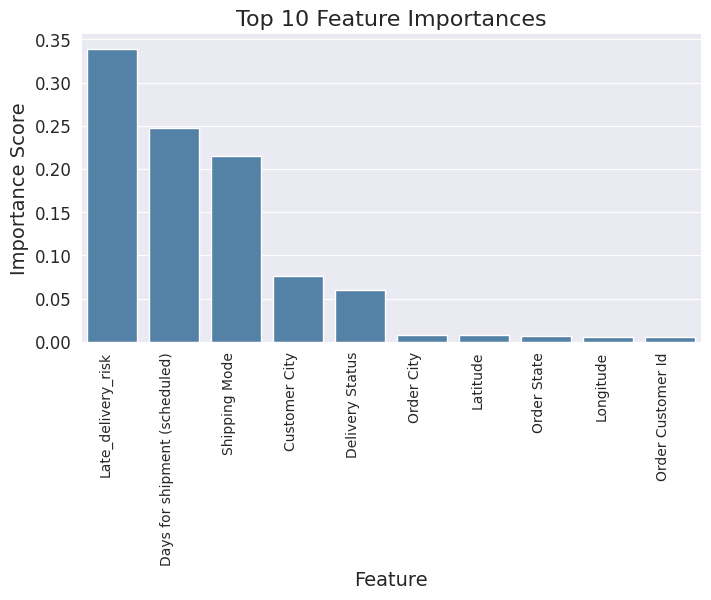

In [ ]:
# Top 10 Feature Importances

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# get the feature importances
importances = model.feature_importances_

# sort the features by importance
sorted_idx = importances.argsort()[::-1]

# set style for the plot
sns.set_style('darkgrid')

# select the top 10 features
top_features = X.columns[sorted_idx][:10]
top_importances = importances[sorted_idx][:10]

# create a figure and axis objects
fig, ax = plt.subplots(figsize=(8, 4))

# create a bar chart of the top 10 features
sns.barplot(x=top_features, y=top_importances, ax=ax, color='steelblue')

# set x-axis label and rotate labels for readability
ax.set_xlabel('Feature', fontsize=14)
ax.set_xticklabels(top_features, rotation=90, ha='right', fontsize=10)

# set y-axis label and tick labels
ax.set_ylabel('Importance Score', fontsize=14)
ax.tick_params(axis='y', labelsize=12)

# set title
ax.set_title('Top 10 Feature Importances', fontsize=16)

# remove top and right spines
sns.despine()

# show the plot
plt.show()

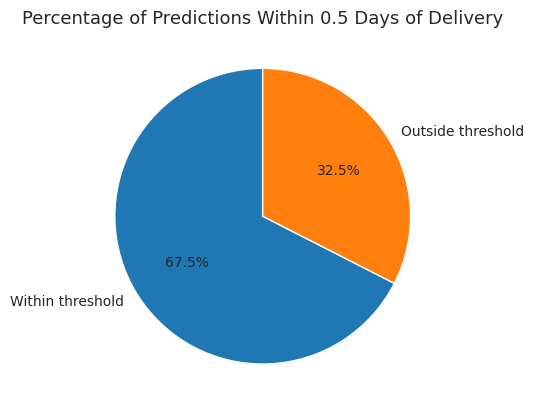

In [ ]:
import matplotlib.pyplot as plt

# Set the threshold value
threshold = 0.5

# Get the predicted values
y_pred = model.predict(X_test)

# Calculate the percentage of predictions within the threshold value
within_threshold = (np.abs(y_pred - y_test) < threshold).mean()

# Calculate the percentage of predictions outside the threshold value
outside_threshold = 1 - within_threshold

# Create a pie chart
fig, ax = plt.subplots()
labels = ['Within threshold', 'Outside threshold']
sizes = [within_threshold, outside_threshold]
colors = ['#1f77b4', '#ff7f0e']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Percentage of Predictions Within 0.5 Days of Delivery', fontsize=13)

# Show the plot
plt.show()

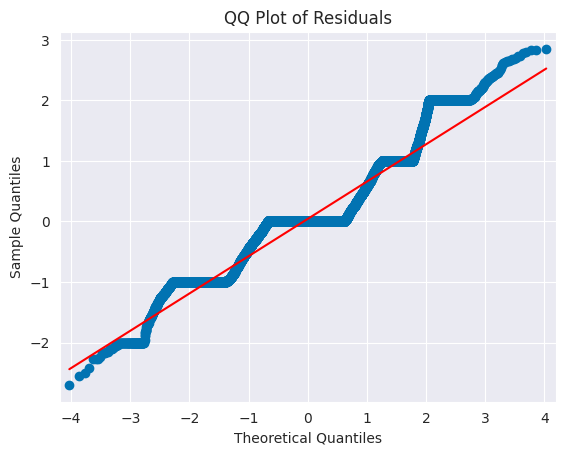

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# Get the residuals
residuals = y_test - y_pred

# Create a QQ plot
qqplot(residuals, line='s')

# Add title and axis labels
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show the plot
plt.show()